# Importing Libraries

In [1]:
!pip install shap

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import OneHotEncoder,MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from shap import Explainer
from shap.plots import bar as shapley_bar

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier,plot_tree

# Importing Data

Code to import dataset taken from [the uci.edu webpage](https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data).

In [3]:
!pip install ucimlrepo

In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
statlog_german_credit_data = fetch_ucirepo(id=144)

# data (as pandas dataframes)
X = statlog_german_credit_data.data.features
y = statlog_german_credit_data.data.targets

# metadata
print(statlog_german_credit_data.metadata)

# variable information
print(statlog_german_credit_data.variables)

{'uci_id': 144, 'name': 'Statlog (German Credit Data)', 'repository_url': 'https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data', 'data_url': 'https://archive.ics.uci.edu/static/public/144/data.csv', 'abstract': 'This dataset classifies people described by a set of attributes as good or bad credit risks. Comes in two formats (one all numeric). Also comes with a cost matrix', 'area': 'Social Science', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1000, 'num_features': 20, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Other', 'Marital Status', 'Age', 'Occupation'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1994, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5NC77', 'creators': ['Hans Hofmann'], 'intro_paper': None, 'additional_info': {'summary': 'Two datasets are provided.  the original dataset, in the form provided by

# Preprocessing Data

Splitting to train and test sets, stratifying by the target values.

In [5]:
seed=0

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=y)

X_val,X_test,y_val,y_test = train_test_split(X_train,y_train,test_size=0.25,random_state=seed,stratify=y_train)

Encoding categorical features to OneHot vectors and normalizing numerical features.

In [6]:
OHE = OneHotEncoder(drop='if_binary',handle_unknown='ignore',sparse_output=False)
categorical_columns = ['Attribute1','Attribute3','Attribute4','Attribute6','Attribute7','Attribute9','Attribute10','Attribute12','Attribute14','Attribute15','Attribute17','Attribute19', 'Attribute20']

MMS = MinMaxScaler()
numerical_columns = ['Attribute2','Attribute5','Attribute8','Attribute11','Attribute13','Attribute16','Attribute18']

transformer = ColumnTransformer([('onehot', OHE, categorical_columns),('scaling',MMS,numerical_columns)]).fit(X_train)

X_train_enc = transformer.transform(X_train)
X_test_enc = transformer.transform(X_test)
X_val_enc = transformer.transform(X_val)

# Training Models

## White-Box Model: Decision Tree

In [7]:
tree = DecisionTreeClassifier(max_depth=5)

tree.fit(X_train_enc,y_train)
y_pred_tree = tree.predict(X_test_enc)

print(classification_report(y_test,y_pred_tree))

              precision    recall  f1-score   support

           1       0.83      0.88      0.85       140
           2       0.67      0.58      0.63        60

    accuracy                           0.79       200
   macro avg       0.75      0.73      0.74       200
weighted avg       0.78      0.79      0.79       200



## Black-Box Model: SVM (RBF Kernel)

In [8]:
svm = SVC()

svm.fit(X_train_enc,y_train)
y_pred_svm = svm.predict(X_test_enc)

print(classification_report(y_test,y_pred_svm))

              precision    recall  f1-score   support

           1       0.86      0.99      0.92       140
           2       0.97      0.63      0.77        60

    accuracy                           0.89       200
   macro avg       0.92      0.81      0.85       200
weighted avg       0.90      0.89      0.88       200



/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Commentary
Neither model is doing very well, but that's fine for our purposes, as long as the black-box model is performing better than the white-box model.

# Global Explanations

This is the initial dataset:

In [9]:
display(X)

,Attribute1,Attribute2,Attribute3,Attribute4,Attribute5,Attribute6,Attribute7,Attribute8,Attribute9,Attribute10,Attribute11,Attribute12,Attribute13,Attribute14,Attribute15,Attribute16,Attribute17,Attribute18,Attribute19,Attribute20
0,A11,6,A34,A43,1169,A65,A75,4,A93,A101,4,A121,67,A143,A152,2,A173,1,A192,A201
1,A12,48,A32,A43,5951,A61,A73,2,A92,A101,2,A121,22,A143,A152,1,A173,1,A191,A201
2,A14,12,A34,A46,2096,A61,A74,2,A93,A101,3,A121,49,A143,A152,1,A172,2,A191,A201
3,A11,42,A32,A42,7882,A61,A74,2,A93,A103,4,A122,45,A143,A153,1,A173,2,A191,A201
4,A11,24,A33,A40,4870,A61,A73,3,A93,A101,4,A124,53,A143,A153,2,A173,2,A191,A201
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12,A32,A42,1736,A61,A74,3,A92,A101,4,A121,31,A143,A152,1,A172,1,A191,A201
996,A11,30,A32,A41,3857,A61,A73,4,A91,A101,4,A122,40,A143,A152,1,A174,1,A192,A201
997,A14,12,A32,A43,804,A61,A75,4,A93,A101,4,A123,38,A143,A152,1,A173,1,A191,A201
998,A11,45,A32,A43,1845,A61,A73,4,A93,A101,4,A124,23,A143,A153,1,A173,1,A192,A201


This is the decision tree we have made on the transformed dataset:

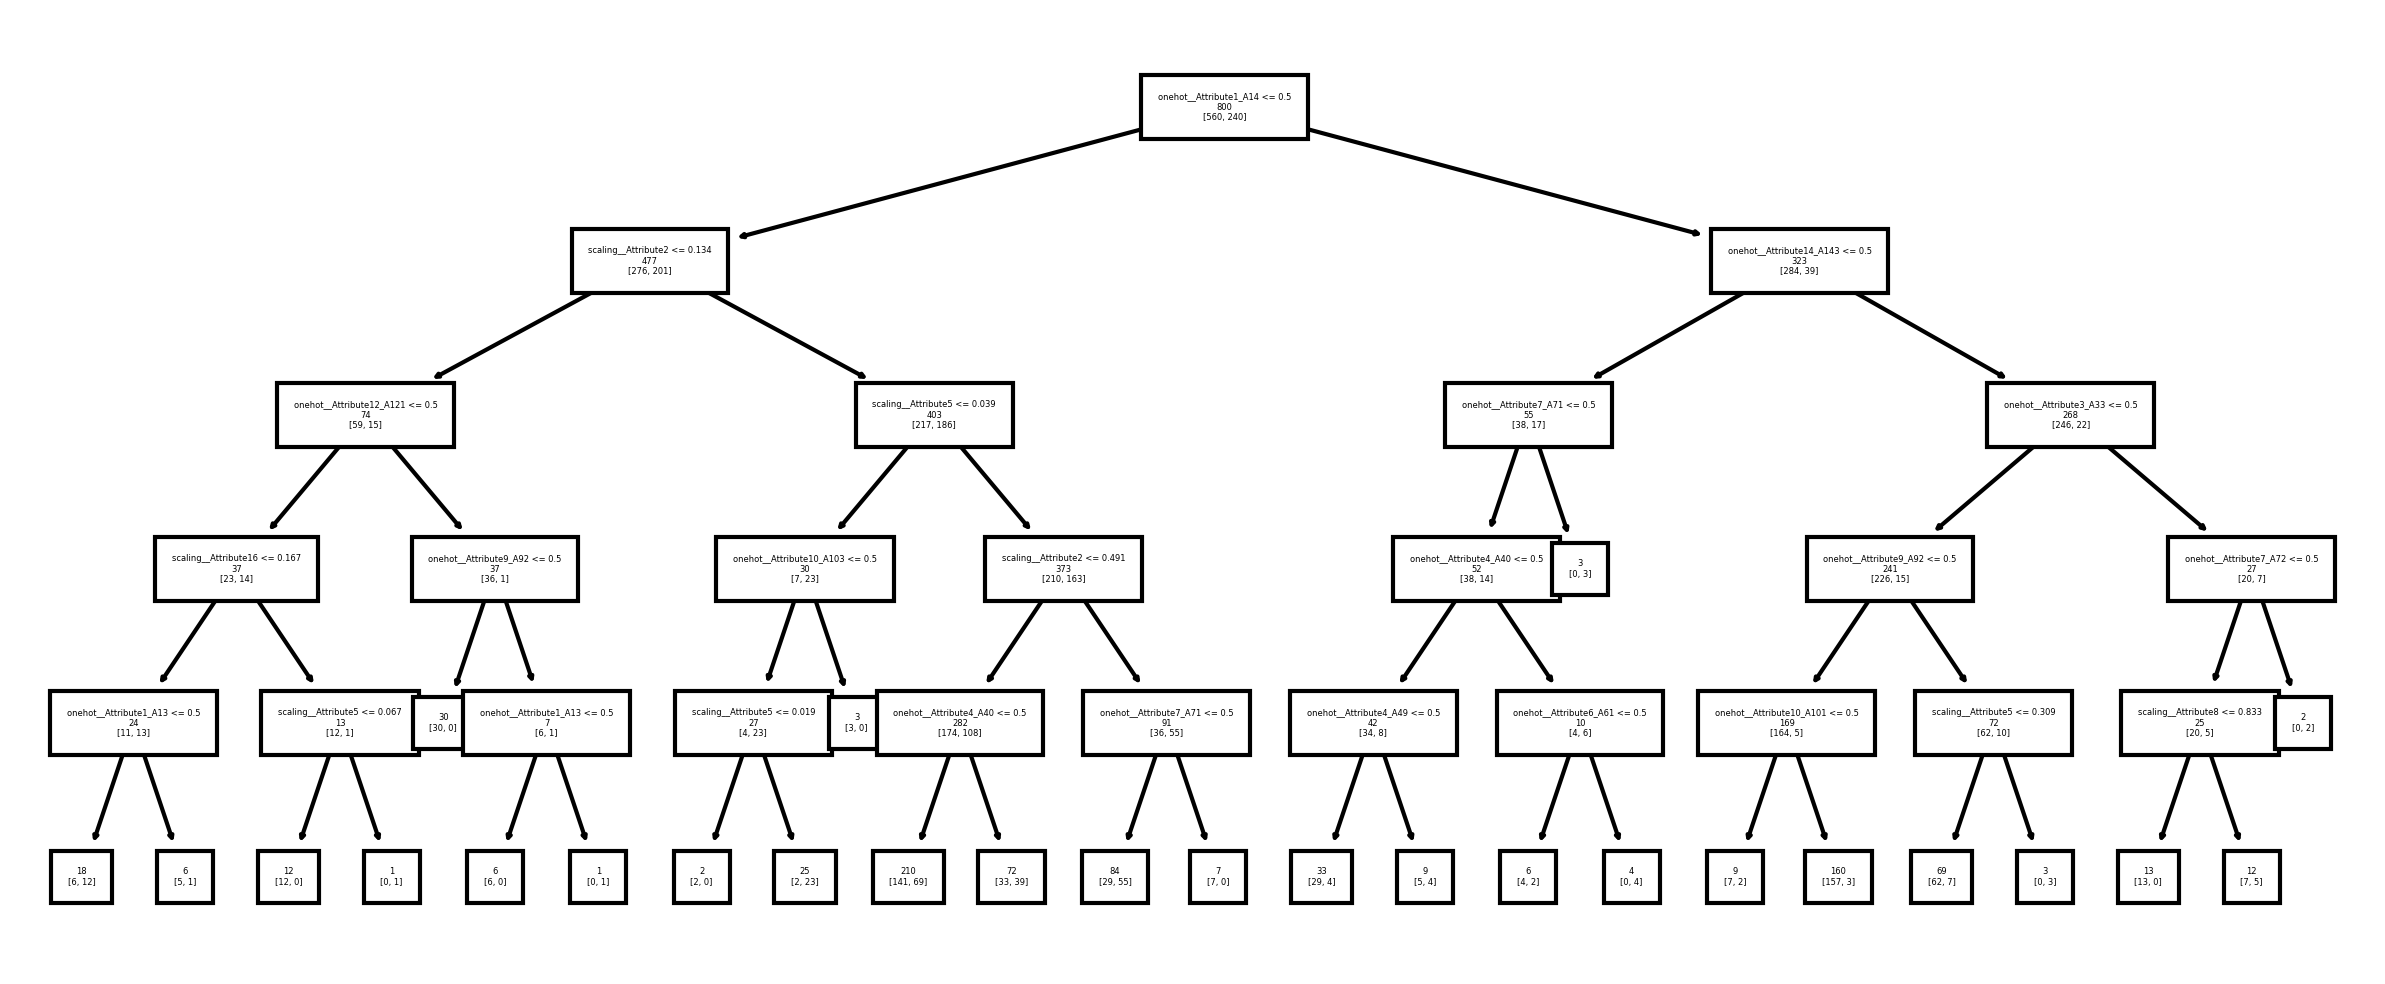

In [10]:
plt.figure(figsize=(10, 4), dpi=300)
plot_tree(tree,label='none',impurity=False,feature_names=transformer.get_feature_names_out(),fontsize=2)
plt.show()

The tree above is a global explanation of its full decision-making process. However, the actual meaning of these rules is not very obvious to a human observer. However, by reversing the scaling on the numeric attributes and interpreting the onehot attributes as their respective values in the initial dataset, and with the help of a domain expert, it is possible to extract a proper set of rules that the tree abides by.

For our SVM model, we can achieve a global explanation by calculating the permutation importance of each feature.
Code is modified from a [StackOverflow answer](https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn/67910281#67910281) to better represent the features in this instance.

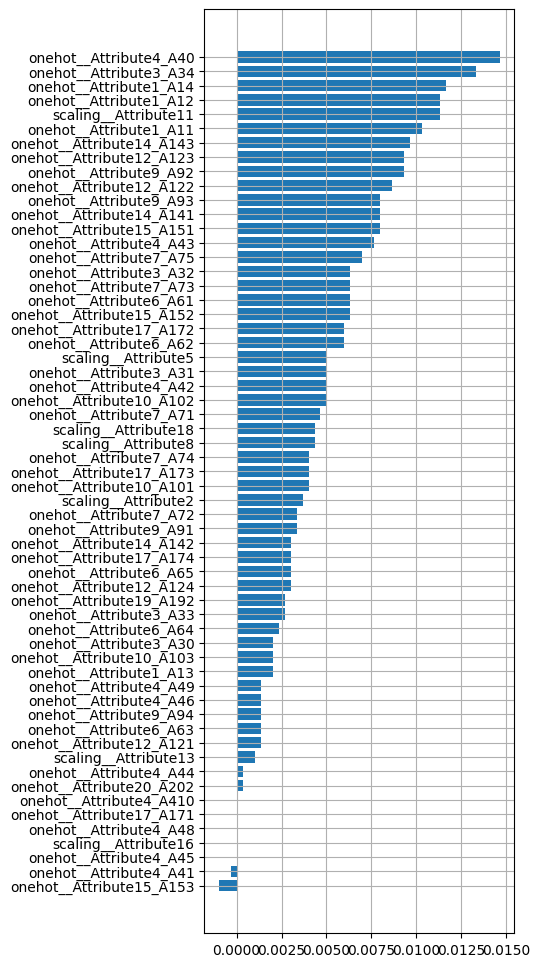

In [11]:
perm_importance = permutation_importance(svm, X_val_enc, y_val)

features = np.array(transformer.get_feature_names_out())
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(4, 12))
plt.grid()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.show()

This essentially ranks our features by importance in the decision-making process of our model. Like with the tree model, a domain expert should be consulted for a more human-readable explanation.

# Local Explanations

First, we pick a random example from our validation set.

In [12]:
random.seed(0)

example = random.choice(range(X_val_enc.shape[0]))

example_x = X_val_enc[example]
example_y = list(y_val.iloc[example])[0]
print(f"X vector:\n{example_x}\nTarget value: {example_y}")

X vector:
[1.         0.         0.         0.         0.         0.
 1.         0.         0.         0.         1.         0.
 0.         0.         0.         0.         0.         0.
 0.         1.         0.         0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         1.         0.         1.         0.         0.
 0.         1.         0.         0.         0.         0.
 1.         0.         1.         0.         0.         0.
 1.         0.         0.         0.         0.57142857 0.43903378
 0.33333333 0.33333333 0.125      0.         1.        ]
Target value: 2


Then, we see what our models predict.

In [13]:
example_tree = tree.predict(example_x.reshape(1, -1))[0]
example_svm = svm.predict(example_x.reshape(1, -1))[0]

print(f"   Target value: {example_y}\nTree prediction: {example_tree}\n SVM prediction: {example_svm}")

   Target value: 2
Tree prediction: 2
 SVM prediction: 2


Oh, we got correct predictions from both models, even though our example is from the class they're both doing worse at. That's lucky.

Now, to produce a local explanation for our tree model, all we need to do is follow the decision tree. First, let's label the features of our example appropriately:

In [14]:
dict(zip(transformer.get_feature_names_out(),example_x))

{'onehot__Attribute1_A11': 1.0,
 'onehot__Attribute1_A12': 0.0,
 'onehot__Attribute1_A13': 0.0,
 'onehot__Attribute1_A14': 0.0,
 'onehot__Attribute3_A30': 0.0,
 'onehot__Attribute3_A31': 0.0,
 'onehot__Attribute3_A32': 1.0,
 'onehot__Attribute3_A33': 0.0,
 'onehot__Attribute3_A34': 0.0,
 'onehot__Attribute4_A40': 0.0,
 'onehot__Attribute4_A41': 1.0,
 'onehot__Attribute4_A410': 0.0,
 'onehot__Attribute4_A42': 0.0,
 'onehot__Attribute4_A43': 0.0,
 'onehot__Attribute4_A44': 0.0,
 'onehot__Attribute4_A45': 0.0,
 'onehot__Attribute4_A46': 0.0,
 'onehot__Attribute4_A48': 0.0,
 'onehot__Attribute4_A49': 0.0,
 'onehot__Attribute6_A61': 1.0,
 'onehot__Attribute6_A62': 0.0,
 'onehot__Attribute6_A63': 0.0,
 'onehot__Attribute6_A64': 0.0,
 'onehot__Attribute6_A65': 0.0,
 'onehot__Attribute7_A71': 0.0,
 'onehot__Attribute7_A72': 0.0,
 'onehot__Attribute7_A73': 1.0,
 'onehot__Attribute7_A74': 0.0,
 'onehot__Attribute7_A75': 0.0,
 'onehot__Attribute9_A91': 0.0,
 'onehot__Attribute9_A92': 0.0,
 'oneho

So, the process is as follows:  
The model sees that onehot__Attribute1_A14 is 0, then checks scaling__Attribute2.  
It sees that scaling__Attribute2 is greater than 0.134, so it will check scaling__Attribute5 next.  
It sees that scaling__Attribute5 is greater than 0.039, so its next check will be scaling__Attribute2 again.
As scaling__Attribute2 is also greater than 0.491, it'll perform one last check on onehot__Attribute7_A71.
onehot__Attribute7_A71 is 0, so the model ends on a leaf where the majority class is 2.
And that's the model's prediction: that this example is likely to belong in class 2.

To produce a local explanation for our SVM model, we'll use Shapley values. These work by essentially picking one column to remain constant while the rest of the columns may or may not be randomly altered, the calculating the difference in the resulting prediction. By repeating this for many iterations, it's possible to find how much a feature actually contributes to the end result.

In [15]:
explainer = Explainer(svm.predict,X_val_enc,algorithm='permutation')
shap_values = explainer.explain_row(example_x,batch_size=1,max_evals=200,main_effects=True,error_bounds=True,outputs=True,silent=True)

Now let's plot that out.

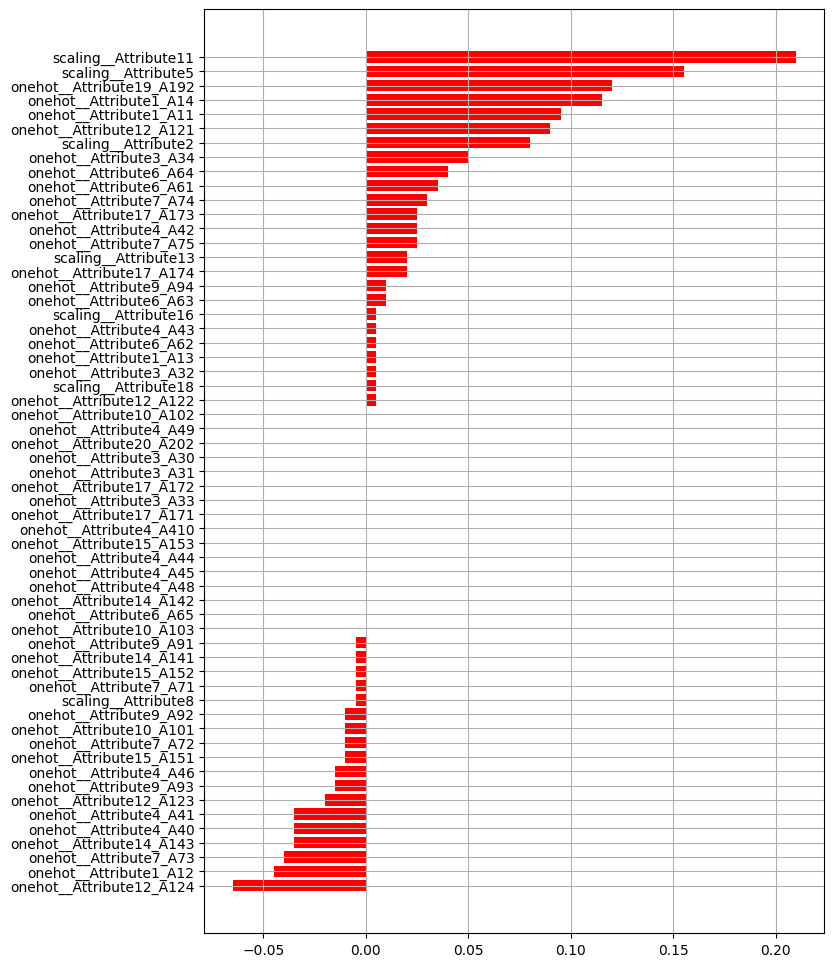

In [16]:
shap_importance = shap_values['values']

features = np.array(transformer.get_feature_names_out())
sorted_idx = shap_importance.argsort()

plt.figure(figsize=(8, 12))
plt.grid()
plt.barh(features[sorted_idx], shap_importance[sorted_idx],color='red')
plt.show()

With these, we have our result for the decision-making importance of each feature for this particular row. Notice that the ordering is quite different from what we got for our model overall.